In [1]:
import gzip
import json
import statistics
from typing import Iterator

import pandas as pd
from plotnine import *
from surprise import (
    accuracy,
    AlgoBase,
    BaselineOnly,
    Dataset,
    KNNBasic,
    KNNWithZScore,
    NormalPredictor,
    Reader,
    SlopeOne,
    SVD,
)
from surprise.model_selection import cross_validate, train_test_split


pd.set_option("max_colwidth", None)

# Table of Contents

- [Step B.1](#Step-B.1)
- [Step B.2](#Step-B.2)
- [Step B.3](#Step-B.3)
- [Step B.4](#Step-B.4)

In [ ]:
# disclaimer: may not work as is in Windows OS
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget --backups=1 http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

## Step B.1

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [4]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = {
            "user": d["reviewerID"],
            "item": d["asin"],
            "rating": d["overall"],
        }  # keep only the essential data
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [5]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

In [6]:
reader = Reader(rating_scale=(1, 5))

In [7]:
data = Dataset.load_from_df(review_data[["user", "item", "rating"]], reader)

inspect_df(data.df, 10)

shape: (169781, 3)


,user,item,rating
0,A2TYZ821XXK2YZ,3426958910,5.0
1,A3OFSREZADFUDY,3426958910,5.0
2,A2VAMODP8M77NG,3426958910,5.0
3,AAKSLZ9IDTEH0,3426958910,4.0
4,A3OH43OZJLKI09,5557706259,5.0
5,A6JP9YYJCK3WO,5557706259,4.0
6,A20Z0JD766DPG6,5557706259,5.0
7,AXQ89O6YRT7AX,5557706259,5.0
8,A1M379MK8MKGUF,5557706259,5.0
9,AA762OWLWCPQ2,5557706259,5.0


## Step B.2

In [8]:
cv_results = {}

In [9]:
"""
Algorithm predicting a random rating based on the distribution of the training set, 
which is assumed to be normal.
"""
cv_results["NormalPredictor"] = cross_validate(
    algo=NormalPredictor(), data=data, verbose=True, cv=5
)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8889  0.8969  0.8971  0.8913  0.8888  0.8926  0.0037  
MAE (testset)     0.5897  0.5949  0.5948  0.5897  0.5887  0.5915  0.0027  
Fit time          0.13    0.17    0.16    0.16    0.17    0.16    0.02    
Test time         0.22    0.13    0.14    0.14    0.13    0.16    0.03    


In [10]:
"""
Algorithm predicting the baseline estimate for given user and item.
"""
cv_results["BaselineOnly"] = cross_validate(
    algo=BaselineOnly(), data=data, verbose=True, cv=5
)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5825  0.5911  0.5889  0.6022  0.5928  0.5915  0.0064  
MAE (testset)     0.3662  0.3714  0.3685  0.3725  0.3726  0.3702  0.0025  
Fit time          0.39    0.41    0.44    0.40    0.44    0.42    0.02    
Test time         0.08    0.09    0.08    0.09    0.16    0.10    0.03    


In [11]:
"""
A basic item-item collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) item-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": False,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6029  0.6159  0.6110  0.6095  0.6074  0.6094  0.0043  
MAE (testset)     0.3100  0.3171  0.3143  0.3132  0.3121  0.3133  0.0024  
Fit time          4.50    4.36    4.34    4.53    4.52    4.45    0.08    
Test time         0.66    0.65    0.67    0.73    0.61    0.66    0.04    


In [12]:
"""
A simple yet accurate item-based collaborative filtering algorithm.

This is a straightforward implementation of the SlopeOne algorithm: https://arxiv.org/abs/cs/0702144
"""
cv_results["SlopeOne"] = cross_validate(
    algo=SlopeOne(),
    data=data,
    verbose=True,
    cv=5,
)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5846  0.5785  0.5875  0.5791  0.5837  0.5827  0.0034  
MAE (testset)     0.2733  0.2711  0.2735  0.2720  0.2736  0.2727  0.0010  
Fit time          2.51    2.53    2.62    2.64    2.53    2.57    0.05    
Test time         0.45    0.47    0.43    0.47    0.54    0.47    0.04    


In [13]:
"""
A basic user-user collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) user-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7706  0.7668  0.7648  0.7769  0.7763  0.7711  0.0049  
MAE (testset)     0.4666  0.4615  0.4619  0.4691  0.4692  0.4657  0.0034  
Fit time          9.15    9.98    9.57    9.68    8.91    9.46    0.38    
Test time         0.88    1.13    1.24    1.63    0.89    1.16    0.28    


In [14]:
"""
A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.
"""
cv_results["KNNWithZScore (MSD) user-based"] = cross_validate(
    algo=KNNWithZScore(
        sim_options={
            "name": "msd",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5850  0.5883  0.5723  0.5861  0.5898  0.5843  0.0062  
MAE (testset)     0.2911  0.2912  0.2848  0.2913  0.2911  0.2899  0.0025  
Fit time          5.89    5.66    5.63    5.57    5.66    5.68    0.11    
Test time         0.96    0.90    0.90    0.91    0.92    0.92    0.02    


In [15]:
"""
The famous SVD algorithm, as popularized by `Simon Funk
<http://sifter.org/~simon/journal/20061211.html>`_ during the Netflix Prize.
"""
cv_results["SVD"] = cross_validate(algo=SVD(), data=data, verbose=True, cv=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5609  0.5597  0.5579  0.5649  0.5625  0.5612  0.0024  
MAE (testset)     0.3357  0.3331  0.3331  0.3377  0.3355  0.3350  0.0017  
Fit time          5.57    5.55    5.57    5.65    5.60    5.59    0.04    
Test time         0.22    0.22    0.26    0.24    0.16    0.22    0.03    


## Step B.3

In [16]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE"] = df["test_rmse"].map(lambda x: statistics.mean(x))

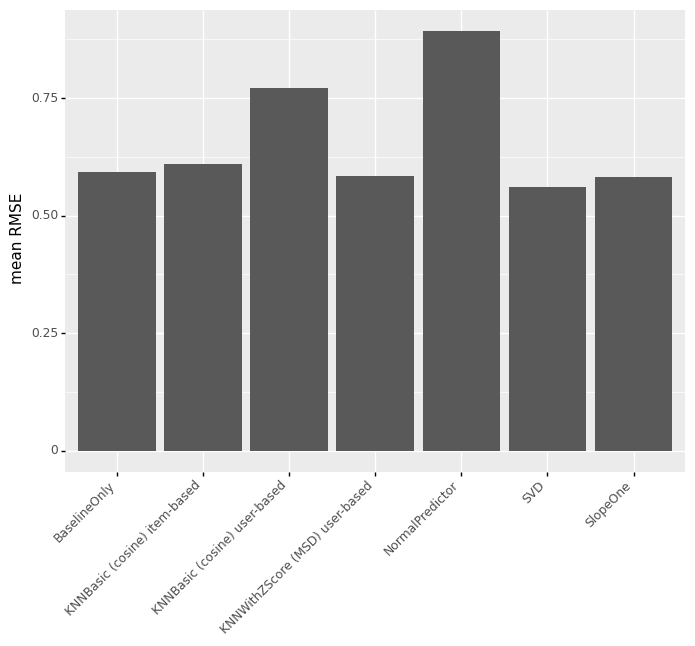

<ggplot: (8728930467313)>

In [17]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE")
)

## Step B.4

In [18]:
trainset, testset = train_test_split(data, test_size=0.25)

In [19]:
recsys = SVD().fit(trainset)

In [20]:
def get_recommendations_for_user(user: str, rs: AlgoBase, n: int = 5) -> list:

    # get n random unseen products for this user
    unseen_items = review_data[review_data["user"] != user]["item"].unique()

    predictions = [*map(lambda item: rs.predict(uid=user, iid=item), unseen_items)]

    return sorted(predictions, key=lambda p: p.est, reverse=True)[:n]

In [21]:
users = list(set((u for u, _, _ in testset)))

for user in users[:5]:  # show recommendations for first 5 users, no need to display all
    for recommendation in get_recommendations_for_user(user, rs=recsys, n=5):
        print(recommendation)
    print("=" * 105)

user: A2BH6YL4S1MY93 item: 7799420340 r_ui = None   est = 5.00   {'was_impossible': False}
user: A2BH6YL4S1MY93 item: B000LWZD7M r_ui = None   est = 5.00   {'was_impossible': False}
user: A2BH6YL4S1MY93 item: B000QO5DAC r_ui = None   est = 5.00   {'was_impossible': False}
user: A2BH6YL4S1MY93 item: B000QOV6YY r_ui = None   est = 5.00   {'was_impossible': False}
user: A2BH6YL4S1MY93 item: B000S3OC5S r_ui = None   est = 5.00   {'was_impossible': False}
user: A31PYWT67U3A93 item: 3426958910 r_ui = None   est = 5.00   {'was_impossible': False}
user: A31PYWT67U3A93 item: 7799420340 r_ui = None   est = 5.00   {'was_impossible': False}
user: A31PYWT67U3A93 item: B0002HA8IA r_ui = None   est = 5.00   {'was_impossible': False}
user: A31PYWT67U3A93 item: B0006TTLIC r_ui = None   est = 5.00   {'was_impossible': False}
user: A31PYWT67U3A93 item: B000BD5OPM r_ui = None   est = 5.00   {'was_impossible': False}
user: A3KX1R4XD4BMXO item: B0006TTLIC r_ui = None   est = 5.00   {'was_impossible': False}

In [22]:
users = pd.DataFrame(dict(user=review_data["user"].unique()))

users["top_recommendations"] = users["user"].map(
    lambda x: get_recommendations_for_user(x, recsys, n=5)
)

In [23]:
users["top_recommendations"] = users["top_recommendations"].map(
    lambda recommendations: [p.iid for p in recommendations]
)

In [24]:
users

,user,top_recommendations
0,A2TYZ821XXK2YZ,"[7799420340, 9714721180, B00004TTUZ, B000EO8VMQ, B000QLO4IM]"
1,A3OFSREZADFUDY,"[7799420340, B0002HA8IA, B000BD5OPM, B000BD8WUQ, B000PHA2XS]"
2,A2VAMODP8M77NG,"[7799420340, B000BD8WUQ, B000QO6B1C, B000S43QJA, B000S50C5A]"
3,AAKSLZ9IDTEH0,"[B007LAZ7L4, B001NYEHT2, B0012ECGIC, B001NJUGV0, B0011Z5JYU]"
4,A3OH43OZJLKI09,"[B001BZF788, B00137MGM4, B002XMJ7IO, B0011W8V20, B0017DHRJ6]"
...,...,...
16561,A2XABEL5QL0BKC,"[B000WLTDIM, B000WS2THW, B000X06GHI, B00136ITNK, B00137QS2I]"
16562,A23OQL552RQ7UN,"[B00138J5SQ, B0075FLUTS, B002L4U5RG, B00122DEFI, B0045KYGG0]"
16563,A17FFQTRJ4JHZ7,"[7799420340, B0006TTLIC, B000QMFUJ8, B000QO6B1C, B000QO76U2]"
16564,A3IIO38JUX49QS,"[9714721180, B000EO8VMQ, B000LWZD7M, B000QOV6YY, B000S3KQOE]"


In [25]:
users.to_pickle('data/collab-filtering-RS.pkl')